In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import seaborn as sns
import pandas as pd
import json
#%matplotlib notebook
%matplotlib inline

In [11]:
DATA_ROOT = '/home/rom/Documents/uni/nip-deeprl-project/data_AB/data'

In [12]:
STATS_PREFIX = 'episode_stats.'
REPLAY_BUFFER_PREFIX ='replay_buffer.episode_'
MANIFEST_NAME = 'experiment.manifest.json'

In [19]:
def running_mean(arr, win_len):
    mean_arr = np.empty_like(arr)
    for i in range(mean_arr.shape[1]):
        mean_arr[:,i] = np.mean(arr[:,i+1-win_len if i >= win_len else 0:i+1], axis=1)
    return mean_arr

def test_running_mean():
    test = np.arange(9, dtype=float).reshape(3,3)
    mean_test = running_mean(test, 2)
    assert (mean_test == np.array([0., 0.5, 1.5, 3., 3.5, 4.5, 6., 6.5, 7.5]).reshape(3,3)).all(), \
        "running_mean(..) is bugged"
test_running_mean()

def read_manifest(directory):
    fname = [f for f in next(os.walk(directory))[2] if f == MANIFEST_NAME][0]
    with open(os.path.join(directory, fname)) as f:
        return json.load(f)

def read_episode_stats(directory):
    run_dirs = next(os.walk(directory))[1]
    
    episode_rewards = []
    episode_lengths = []
    episode_end_times = []
    for i, run_dir in enumerate(run_dirs):
        path = os.path.join(directory, run_dir)
        files = next(os.walk(path))[2]
        episode_rewards.append([])
        episode_lengths.append([])
        episode_end_times.append([])
        for fname in (f for f in files if f.startswith(STATS_PREFIX)):
            with np.load(os.path.join(path,fname)) as data:
                episode_rewards[i].extend(data['episode_rewards'])
                episode_lengths[i].extend(data['episode_lengths'])
                episode_end_times[i].extend(data['episode_end_times'])
    return (np.array([x for x in episode_rewards]), 
            np.array([x for x in episode_lengths]),
            np.array([x for x in episode_end_times]))

def find_avail_setups():
    '''Return dict with key=env, value=list(config1, ..., confign)'''
    setups = {}
    for env in [sd for sd in next(os.walk(DATA_ROOT))[1] if not sd.startswith('.')]:
        setups[env] = [sd for sd in next(os.walk(os.path.join(DATA_ROOT, env)))[1]]
    return setups

def _plot_std_band(*args, central_data=None, ci=None, data=None, **kwargs):
    # Hack seaborne timeseries to show std instead of conf. interval
    std = data.std(axis=0)
    ci = np.asarray((central_data - std, central_data + std))
    kwargs.update({"central_data": central_data, "ci": ci, "data": data})
    sns.timeseries._plot_ci_band(*args, **kwargs)

def plot_data(data, ax, color=None):
    sns.set_context(font_scale=15)
    sns.timeseries._plot_std_band = _plot_std_band
    return sns.tsplot(data, err_style="std_band", n_boot=0, ax=ax, color=color)
    
def visualize_env(env, env_dir):
    
    f, axes = plt.subplots(nrows=len(env), ncols=1, figsize=(20, 6*len(env)))
    if len(env) == 1:
        axes = [axes]
    for i, config in enumerate(env):
        directory = os.path.join(env_dir, config)
        ep_rws, ep_lns, ep_tms = read_episode_stats(directory)
        smoothed_ep_rws = running_mean(ep_rws, 10) # 10
        smoothed_ep_lns = running_mean(ep_lns, 10) # 10
        smoothed_ep_tms = running_mean(ep_tms, 10) # 10
        manifest = read_manifest(directory)
        sec_label = 'Arch:{} - buffer-size:{} - minibatch-size:{} - num_steps:{} - schedule_steps:{}'\
            .format(manifest['args']['arch'],
                    manifest['args']['replay_buffer_size'],
                    manifest['args']['batch_size'],
                    manifest['args']['num_steps'],
                    manifest['args']['schedule_timesteps'])
        # episode in which we hit num_steps
        ep_num_steps = np.argmin(abs(np.cumsum(ep_lns) - manifest['args']['num_steps']))
        # episode in which we stop annealing
        ep_schedule_steps = np.argmin(abs(np.cumsum(ep_lns) - manifest['args']['schedule_timesteps']))
        
    
        plot_data(ep_rws, axes[i], color=sns.color_palette("Blues", 20)[14])
        rws_plot = mpatches.Patch(color=sns.color_palette("Blues", 20)[14])
        
        plot_data(smoothed_ep_rws, axes[i], color=sns.color_palette("Blues", 20)[19])
        smoothed_rws_plot = mpatches.Patch(color=sns.color_palette("Blues", 20)[19])
        
        num_steps_line = axes[i].axvline(ep_num_steps, color='k', linestyle='--', linewidth=1)
        schedule_steps_line = axes[i].axvline(ep_schedule_steps, color='purple', linestyle='--', linewidth=1)
        axes[i].set(xlabel='Episodes', ylabel='Total Reward')
        axes[i].set(title='{}\n{}'.format(config, sec_label))
        axes[i].legend([rws_plot, smoothed_rws_plot, num_steps_line, schedule_steps_line],
                  ['Total Reward + σ', 'Smoothed Total Reward + σ', 'Episode reaching num_steps', 'Episode reaching minimum ε'],
                  fontsize='xx-large', frameon=True, fancybox=True, shadow=True, facecolor='white')

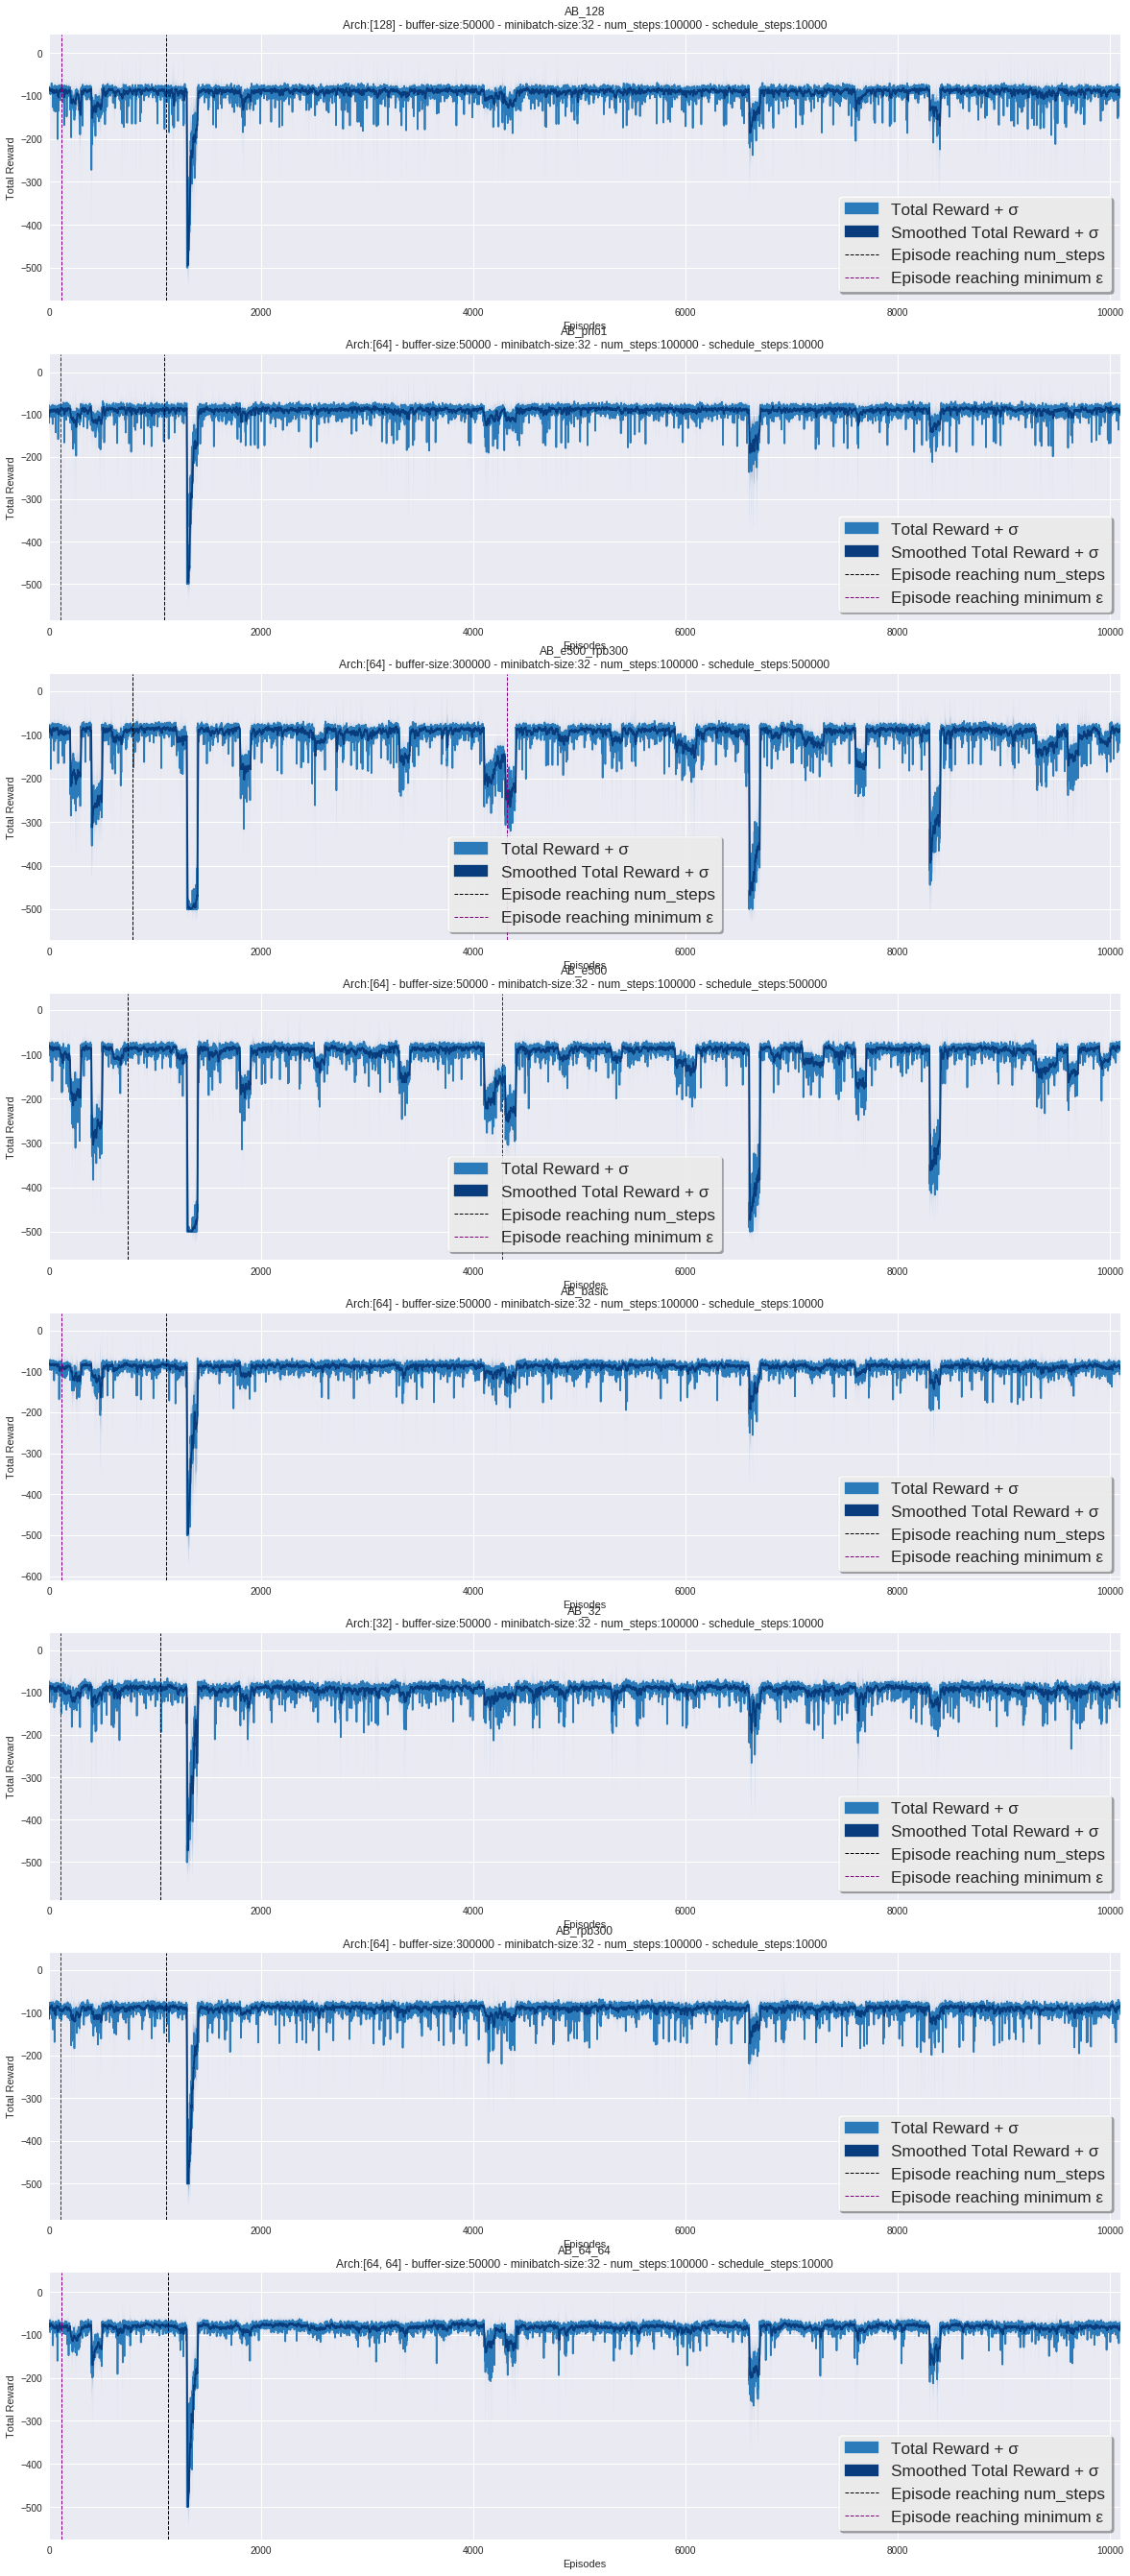

In [20]:
setups = find_avail_setups()
visualize_env(setups['Acrobot-v1'], os.path.join(DATA_ROOT, 'Acrobot-v1'))